In [1]:
import eegPinelineDesign
import numpy as np
import random
import mne
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot') 
import os
import pandas as pd
import re
import json
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA,FastICA
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from scipy.fftpack import fft,ifft
import math
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from scipy.signal import spectrogram,find_peaks_cwt
from mne.preprocessing.ica import ICA
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.cross_validation import train_test_split,ShuffleSplit
from sklearn.preprocessing import label_binarize,scale
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize,StandardScaler
from nitime import algorithms as alg
eegPinelineDesign.change_file_directory('C:/Users/ning/Downloads/training set')
EDFfiles, Annotationfiles = eegPinelineDesign.split_type_of_files()

ImportError: No module named 'nitime'

In [2]:
EDFfiles

C:\Anaconda3\lib\site-packages\IPython\core\formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
C:\Anaconda3\lib\site-packages\IPython\core\formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


['s5d2_final.edf',
 's6n2_final.edf',
 'suj10_d1final.edf',
 'suj10_d2final.edf',
 'suj13_l2nap_day2 edited.edf',
 'suj13_l2nap_day2 edited1.edf',
 'suj5_d1final.edf',
 'suj6_d1final.edf',
 'suj8_d1final.edf',
 'suj8_d2final.edf',
 'suj9_d1final.edf',
 'suj9_d2final.edf']

In [3]:
file_to_read,fileName=eegPinelineDesign.pick_sample_file(EDFfiles,n=-1)
# channel list for artifact(eyemovement or chewing) removal - ROC and/or LOC
channelList = ['F3','F4','C3','C4','O1','O2','ROC','LOC']
raw = eegPinelineDesign.load_data(file_to_read,channelList,None, 100)# low pass
annotation_to_read = [x for x in Annotationfiles if fileName in x]
file = pd.read_csv(annotation_to_read[0])
labelFind = re.compile('spindle',eegPinelineDesign.re.IGNORECASE)
spindles=[]
for row in file.iterrows():
    currentEvent = row[1][-1]
    if labelFind.search(currentEvent):
        spindles.append(row[1][0])
        
sleep_annotation=[]
searchLabel = re.compile('Markon: 2',re.IGNORECASE)
for rows in file.iterrows():
    currentEvent = rows[-1][-1]
    if searchLabel.search(currentEvent):
        sleep_annotation.append([rows[1][0],rows[1][0]+30])

Extracting edf Parameters from suj9_d2final.edf...
Setting channel info structure...
Creating Raw.info structure...
Reading 0 ... 2589999  =      0.000 ...  2589.999 secs...
[done]
Ready.
Fitting ICA to data using 8 channels. 
Please be patient, this may take some time
Inferring max_pca_components from picks.
Using all PCA components: 8
    Searching for artifacts...
    found 1 artifact by EOG 00
    found 1 artifact by skewness
    found 1 artifact by kurtosis
    found 1 artifact by variance
Artifact indices found:
    6, 3, 3, 6
    Removing duplicate indices...
Ready.
Transforming to ICA space (8 components)
Zeroing out 2 ICA components
Inverse transforming to PCA space
Reconstructing sensor space signals from 8 PCA components
Low-pass filtering at 5e+02 Hz
Low-pass filtering at 1e+02 Hz


In [4]:
# threshold test
channelList=['F3','F4','C3','C4','O1','O2']
windowsize = 5;ratio_index={};muscle_index={};sample_ind={};resolution = 1
for ii, names in enumerate(channelList):
    endPoint = windowsize;startPoint=endPoint-windowsize
    distance_to_end = raw.last_samp/1000 - endPoint
    ratio_index[names] =[];muscle_index[names]=[];sample_ind[names]=[];
    
    while distance_to_end > windowsize:
        start,stop = raw.time_as_index([startPoint,endPoint])
        tempSegment,time = raw[ii,start:stop]
        
        
        filter_alpha=mne.filter.band_pass_filter(tempSegment[0,:],1000,8,12.5)
        RMS_alpha=np.sqrt(sum(filter_alpha**2)/len(filter_alpha))
        
        filter_spindle=mne.filter.band_pass_filter(tempSegment[0,:],1000,11,16.5)
        RMS_spindle=np.sqrt(sum(filter_spindle**2)/len(filter_spindle))
        
        filter_muscle=mne.filter.band_pass_filter(tempSegment[0,:],1000,30,40.5)
        RMS_muscle=np.sqrt(sum(filter_muscle**2)/len(filter_muscle))
        
        point=[0,0]
        if RMS_alpha/RMS_spindle <1.2:
            point[0] += 2
            ratio_index[names].append(2)
        else:
            point[0] += -1
            ratio_index[names].append(-1)
            
        if RMS_muscle > 5*10e-4:
            point[1] += -1
            muscle_index[names].append(-1)
        else:
            point[1] += 1
            muscle_index[names].append(1)
            
        sample_ind[names].append(sum(point))
        
        endPoint += resolution
        startPoint = endPoint - windowsize
        distance_to_end = raw.last_samp/1000 - endPoint
    sample_ind[names].append(0)
general_result = pd.DataFrame(sample_ind)

C:\Anaconda3\lib\site-packages\mne\filter.py:333: UserWarning: Attenuation at stop frequency 7.5Hz is only 18.1dB.
  '%0.1fdB.' % (att_freq, att_db))
C:\Anaconda3\lib\site-packages\mne\filter.py:333: UserWarning: Attenuation at stop frequency 17.0Hz is only 17.9dB.
  '%0.1fdB.' % (att_freq, att_db))
C:\Anaconda3\lib\site-packages\mne\filter.py:333: UserWarning: Attenuation at stop frequency 29.5Hz is only 17.9dB.
  '%0.1fdB.' % (att_freq, att_db))


In [5]:
mark_pairs={};indicator={}
for ii, names in enumerate(channelList):
    mark_pairs[names]=[];indicator[names]=[]
    for pos,item in enumerate(general_result[names]):
        
        if pos == len(general_result[names])-1:
            pass
        else:
            indicator[names].append(general_result[names][pos+1]-general_result[names][pos])
            
            if indicator[names][pos] == -3:
                endPoint = pos * resolution
                initial_position = pos; position_idx = pos
                try:
                    while indicator[names][initial_position] != 3:
                        position_idx -= 1
                        initial_position = position_idx
                    startPoint = position_idx * resolution
                    
                    if endPoint - startPoint >= 1:
                        mark_pairs[names].append((startPoint,endPoint))
                except:
                    pass

In [ ]:
plt.figure(figsize=(20,20))
for ii, names in enumerate(channelList):
    for item in mark_pairs[names]:
        plt.hlines(ii,item[0],item[1])
        
plt.yticks(np.arange(6),channelList)
plt.ylim([-1,6])

In [149]:
spindle_overlapping=[]

for items in spindles:
    spindle_overlapping_temp=[]
    for names in channelList:
        if any(lower < items < upper for (lower,upper) in mark_pairs[names]):
            spindle_overlapping_temp.append(items)
    spindle_overlapping.append(list(set(spindle_overlapping_temp)))
    
    
len(spindle_overlapping)

140

In [6]:
# whether two intervals overlap
def getOverlap(a,b):
    return max(0,min(a[1],b[1]) - max(a[0],b[0]))

In [ ]:
sleeping_overlapping ={}
for names in channelList:
    sleeping_overlapping[names]=[]
    for items in sleep_annotation:
        for intervals in mark_pairs[names]:
            #print(names,list(intervals),items,getOverlap(list(intervals),items))
            if getOverlap(list(intervals),items) is not 0:
                sleeping_overlapping[names].append(list(intervals))
                print(names,sleeping_overlapping[names])

In [ ]:
print(sleeping_overlapping)

In [ ]:
plt.figure(figsize=(20,20))
for ii, names in enumerate(channelList):
    for item in sleeping_overlapping[names]:
        plt.hlines(ii,item[0],item[1])
        
plt.yticks(np.arange(6),channelList)
plt.ylim([-1,6])

In [ ]:

TimeWindows={}
for names in channelList:
    TimePoint = 0
    distance_to_end=raw.last_samp/1000 - TimePoint
    resolution =1
    TimeWindows[names] = []
    while distance_to_end > resolution:
        TimeWindows_temp=[]
        for items in sleeping_overlapping[names]:
            if items[0]<TimePoint<items[1]:
                TimeWindows_temp.append(1)
            else:
                TimeWindows_temp.append(0)
        if 1 in TimeWindows_temp:
            TimeWindows[names].append(1)
        else:
            TimeWindows[names].append(0)
        TimePoint += resolution
        distance_to_end = raw.last_samp/1000 - TimePoint

In [ ]:
for keys in TimeWindows.keys():
    print(sum(TimeWindows[keys]))

In [ ]:
for ii, keys in enumerate(TimeWindows.keys()):
    if ii == 0:
        tempData = np.array(TimeWindows[keys])
    else:
        tempData = np.array(TimeWindows[keys])

In [ ]:
f=plt.figure(figsize=(20,20))
ax=f.add_subplot(111)
ax.bar(np.arange(4),[len(spindles),len(spindle_overlapping),len(np.nonzero(tempData)[0]),len(sleeping_overlapping)],.8,align='center')
ax.set_xticks(np.arange(4))
ax.set_xticklabels(['man mark spindles','spindle X threshold','just threshold','sleeping X threshold'])

In [ ]:
TrainingLabel=[]
TrainingData = []
totoal_lenght = 0
Fs=1000

channelList = ['F3','F4','C3','C4','O1','O2','ROC','LOC']
raw = eegPinelineDesign.load_data(file_to_read,channelList,None, None)# no pass
annotation_to_read = [x for x in Annotationfiles if fileName in x]
file = pd.read_csv(annotation_to_read[0]);labelFind = re.compile('Markon',re.IGNORECASE)
# get window sample and window start:end
for row in file.iterrows():
    currentEvent = row[1][-1]
    if labelFind.search(currentEvent):
        items = currentEvent[-1]
        
    if items not in ['w','1','2','3']:
        print('not putting in')
    else:
                
        if items == 'w':
            TrainingLabel.append(0)
                
        elif items == '1':
            TrainingLabel.append(1)
                
        elif items == '2':
            TrainingLabel.append(2)
                
        elif items == '3':
            TrainingLabel.append(3)
        #print('done labeling')
        startPoint = row[1][0];endPoint = startPoint+30
        start,stop = raw.time_as_index([startPoint,endPoint])
        tempDataSet = []
        for index,chan_names in enumerate(['F3','F4','C3','C4','O1','O2']):
            # put the training instance to traning data set and make sure they are the same length
            tempSegment,time = raw[ii,start:stop]
            tempDataSet.append(tempSegment)
                        
        TrainingData.append(np.array(tempDataSet).flatten())

In [7]:
# find all spindle windows
spindle_training_data=[]
for instance in spindles:
    
    tempData=[]
    for ii,names in enumerate(['F3','F4','C3','C4','O1','O2']):
        startPoint = instance-2.5;endPoint = instance+2.5
        start,stop=raw.time_as_index([startPoint,endPoint])
        tempSegment,timeSpan = raw[ii,start:stop]
        centerxval = timeSpan[np.argmax(abs(tempSegment[0,:]))]
        startPoint=centerxval-1.5;endPoint=centerxval+1.5
        start,stop = raw.time_as_index([startPoint,endPoint])
        tempSegment, time = raw[ii,start:stop]
        tempData = np.append(tempData,tempSegment)
    spindle_training_data.append(tempData)

In [14]:
np.array(spindle_training_data).shape

(37, 18000)

In [25]:
# find all non spindle windows  

non_spindle_window=[]
used_time_windows=[]
#instance = np.random.choice(np.arange(raw.last_samp/1000),1)
#startPoint = instance - 1; endPoint = instance + 1
# theshold check:
for ii in range(len(spindle_training_data)):
    Chan = [False,False,False,False,False,False,False,False]
    while sum(np.array(Chan).astype(int)) < 7:
        instance = np.random.choice(np.arange(raw.last_samp/1000),1)
        startPoint = instance - 1; endPoint = instance + 1
        
        for idx,names in enumerate(['F3','F4','C3','C4','O1','O2']):
            Chan[idx]=any(getOverlap([instance -1,instance + 1],[lower,upper]) !=0 for (lower,upper) in mark_pairs[names])
        Chan[6] = all(getOverlap([startPoint,endPoint],[instance-1.5,instance+1.5])==0 for instance in spindles)
        Chan[7] = all(getOverlap([startPoint,endPoint],[lower,upper])!=0  for (lower,upper) in used_time_windows)
        print(Chan)
    used_time_windows.append([startPoint,endPoint])
    tempData=[]
    for idxx,names in enumerate(['F3','F4','C3','C4','O1','O2']):
        startPoint = instance-1.5;endPoint = instance+1.5
        start,stop = raw.time_as_index([startPoint,endPoint])
        tempSegment, time = raw[idxx,start:stop]
        tempData = np.append(tempData,tempSegment)
    non_spindle_window.append(tempData)
    print(len(non_spindle_window),ii)
    

[False, False, False, False, False, False, True, True]
[False, True, False, True, False, False, True, True]
[True, True, True, True, True, True, True, True]
1 0
[True, False, False, False, False, False, True, False]
[False, False, False, False, False, False, True, False]
[True, True, True, True, True, True, True, False]
2 1
[True, True, True, True, True, True, True, False]
3 2
[True, True, True, False, True, False, True, False]
[False, False, False, False, False, False, True, False]
[True, True, True, True, True, True, True, False]
4 3
[True, True, True, True, True, False, True, False]
[True, True, True, True, True, True, True, False]
5 4
[True, True, True, True, True, True, True, False]
6 5
[True, True, True, True, True, True, True, False]
7 6
[True, True, True, True, True, True, True, False]
8 7
[False, False, False, False, False, False, True, False]
[True, True, True, True, True, True, False, False]
[True, True, True, True, True, True, True, False]
9 8
[True, True, True, True, True,

C:\Anaconda3\lib\site-packages\mne\io\base.py:544: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  data = self._data[sel, start:stop]
C:\Anaconda3\lib\site-packages\mne\io\base.py:549: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  times = self.times[start:stop]


In [26]:
np.array(non_spindle_window).shape

(37, 18000)

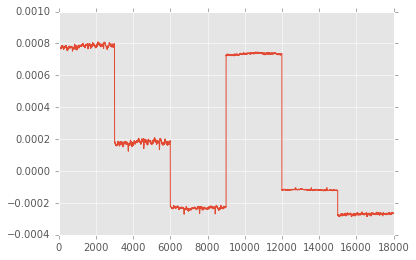

In [27]:
plt.plot(non_spindle_window[0])